# Variable Expert Analysis - Unified Notebook

This notebook supports both model sizes:
- **OpenWebText**: 4x2944 + 4x128 experts
- **WikiText**: 4x2432 + 4x128 experts

Simply change the `DATASET` variable in the config cell to switch between them.

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from tqdm import tqdm
import tiktoken

from model import GPTConfig, MoeMLPWithTracking, GPTWithTracking


torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision('high')  # Or 'medium' for even more speed

In [2]:
# ========== CONFIGURATION ==========
# Change this to switch between datasets and model sizes
DATASET = "openwebtext"  # Options: "openwebtext" or "wikitext"
SEED = 42# Options: 42, 1223, 1337

# Dataset-specific configurations
CONFIGS = {
    "openwebtext": {
        "n_layer": 12,
        "n_head": 12,
        "n_embd": 768,
        "vocab_size": 50304,
        "expert_sizes": [(4, 2944), (4, 128)],  # 4 large (2944) + 4 small (128)
        # "expert_sizes": [(8, 1536)],
        # "checkpoint_dir": f"out-openwebtext/moe-8x2-variable-4x2944-4x128-seed{SEED}",
        # "checkpoint_dir": "out-openwebtext/moe-8x2-8x1536",
        "checkpoint_dir": f"gpt2_experiments/multiseed_23to1_20251102_203832/ratio23_lbl0.01_compute0.004_seed{SEED}",
        "val_data_path": "data/openwebtext/val.bin",
        "model_name": "OpenWebText (4x2944 + 4x128)"
        # "model_name": "OpenWebText Regular MoE"
    },
    "wikitext": {
        "n_layer": 8,
        "n_head": 8,
        "n_embd": 640,
        "vocab_size": 8192,
        "expert_sizes": [(4, 2432), (4, 128)],  # 4 large (2432) + 4 small (128)
        "checkpoint_dir": f"out-wikitext/moe-8x2-variable-4x2432-4x128-seed{SEED}",
        "val_data_path": "data/wikitext/val.bin",
        "model_name": "WikiText (4x2432 + 4x128)"
    }
}

# Select configuration
cfg = CONFIGS[DATASET]

# Create model config
config = GPTConfig(
    n_layer = cfg['n_layer'],
    n_head = cfg['n_head'],
    n_embd = cfg['n_embd'],
    bias = False,
    vocab_size= cfg['vocab_size'],
    
    # MoE configuration with VARIABLE-SIZE EXPERTS
    use_moe = True,
    num_experts = 8,
    num_experts_per_tok = 2,
    norm_topk_prob = True,
    block_size = 128,
    block_k = 64,
    expert_sizes = cfg["expert_sizes"]
)

print(f"\n{'='*60}")
print(f"Configuration: {cfg['model_name']}")
print(f"Seed: {SEED}")
print(f"Expert sizes: {config.expert_sizes}")
print(f"Checkpoint: {cfg['checkpoint_dir']}/ckpt.pt")
print(f"Val data: {cfg['val_data_path']}")
print(f"{'='*60}\n")


Configuration: OpenWebText (4x2944 + 4x128)
Seed: 42
Expert sizes: [(4, 2944), (4, 128)]
Checkpoint: gpt2_experiments/multiseed_23to1_20251102_203832/ratio23_lbl0.01_compute0.004_seed42/ckpt.pt
Val data: data/openwebtext/val.bin



## Load Model and Checkpoint

In [3]:
checkpoint_path = f"{cfg['checkpoint_dir']}/ckpt.pt"

model = GPTWithTracking(config).to(torch.bfloat16)

for block in model.transformer.h:
    if hasattr(block.mlp, 'expert_sizes'):
        old_mlp = block.mlp
        block.mlp = MoeMLPWithTracking(config).to(torch.bfloat16)
        block.mlp.load_state_dict(old_mlp.state_dict())

checkpoint = torch.load(checkpoint_path, map_location='cpu')

state_dict = checkpoint['model']
if any(k.startswith('_orig_mod.') for k in state_dict.keys()):
    state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}

model.load_state_dict(state_dict)

print(f"✓ Loaded checkpoint from {checkpoint_path}")

number of parameters: 293.53M
active parameters per token (expected): 123.66M
  range: 71.76M (min) to 175.57M (max)
✓ Loaded checkpoint from gpt2_experiments/multiseed_23to1_20251102_203832/ratio23_lbl0.01_compute0.004_seed42/ckpt.pt


## Collect ALL Routing Statistics in a SINGLE Pass

This cell collects all statistics (individual expert assignments and combinations) in one efficient pass through the validation set.

In [4]:
tokenizer = tiktoken.get_encoding('gpt2')

val_data_path = cfg['val_data_path']
val_data = np.memmap(val_data_path, dtype=np.uint16, mode='r')

device = 'cuda'
model = model.to(device)
model.eval()

num_layers = config.n_layer
expert_sizes = model.transformer.h[0].mlp.expert_sizes

# Initialize ALL tracking structures
token_stats_per_layer = {}
token_combinations_per_layer = {}

for layer_idx in range(num_layers):
    layer_name = f'layer_{layer_idx}'
    token_stats_per_layer[layer_name] = defaultdict(lambda: {
        'expert_counts': np.zeros(config.num_experts, dtype=np.int64),
        'total_occurrences': 0,
        'total_entropy': 0.0,
        'total_layer_entropy': 0.0,
        'expert_size_sum': 0.0,
    })
    token_combinations_per_layer[layer_name] = defaultdict(Counter)

batch_size = 1
seq_len = 1024
total_tokens = len(val_data)
num_batches = total_tokens // seq_len

print(f"Running single pass through {num_batches} batches to collect all statistics...")

for batch_idx in tqdm(range(num_batches)):
    start_idx = batch_idx * seq_len
    end_idx = start_idx + seq_len
    batch_tokens = torch.from_numpy(val_data[start_idx:end_idx].astype(np.int64)).unsqueeze(0).to(device)

    with torch.inference_mode():
        logits, loss, aux_loss = model(batch_tokens, targets=batch_tokens)

    output_probs = F.softmax(logits[0], dim=-1)
    epsilon = 1e-10
    output_entropy = -(output_probs * torch.log(output_probs + epsilon)).sum(dim=-1).float().cpu().numpy()

    for layer_idx in range(num_layers):
        layer_name = f'layer_{layer_idx}'
        layer_assignments = aux_loss['expert_assignments'][layer_name][0].cpu().numpy()
        layer_entropies = aux_loss['layer_entropies'][layer_name][0].cpu().numpy()
        token_stats = token_stats_per_layer[layer_name]

        for pos in range(seq_len):
            token_id = int(batch_tokens[0, pos].item())
            expert_ids = layer_assignments[pos]

            # Update individual expert statistics
            token_stats[token_id]['total_occurrences'] += 1
            token_stats[token_id]['total_entropy'] += output_entropy[pos]
            token_stats[token_id]['total_layer_entropy'] += layer_entropies[pos]

            for expert_id in expert_ids:
                token_stats[token_id]['expert_counts'][expert_id] += 1
                token_stats[token_id]['expert_size_sum'] += expert_sizes[expert_id]

            # Track expert combinations
            expert_combination = tuple(sorted(expert_ids))
            token_combinations_per_layer[layer_name][token_id][expert_combination] += 1

print(f"\n✓ Collected all statistics in a single pass!")

Running single pass through 4330 batches to collect all statistics...


100%|██████████| 4330/4330 [27:11<00:00,  2.65it/s]


✓ Collected all statistics in a single pass!


## Analysis: Print the Most Common Expert Combination for Each Token

This shows which expert pair each token uses most frequently across all layers.

In [5]:
def format_expert_combo(combo, expert_sizes):
    """Format expert combination with sizes"""
    return ",".join([f"{e}({expert_sizes[e]})" for e in combo])

def print_token_routing_table(token_combinations_per_layer, token_stats_per_layer, expert_sizes, tokenizer, max_tokens=100):
    """Print comprehensive routing table"""
    
    # Calculate average expert size and FLOPs for each token
    token_avg_sizes = {}
    for layer_name in token_stats_per_layer:
        for token_id, stats in token_stats_per_layer[layer_name].items():
            if stats['total_occurrences'] > 0:
                avg_size = stats['expert_size_sum'] / (stats['total_occurrences'] * 2)  # 2 experts per token
                if token_id not in token_avg_sizes:
                    token_avg_sizes[token_id] = []
                token_avg_sizes[token_id].append(avg_size)
    
    overall_avg_sizes = {tid: np.mean(sizes) for tid, sizes in token_avg_sizes.items()}
    
    # Header
    print(f"\n{'='*200}")
    header = f"{'Token ID':<10}{'Token':<20}{'Avg Size':<13}{'FLOPs':<16}"
    for layer_idx in range(num_layers):
        header += f"{'Layer ' + str(layer_idx):<21}"
    print(header)
    print(f"{'='*200}")
    
    # Print first N tokens
    for token_id in sorted(overall_avg_sizes.keys())[:max_tokens]:
        try:
            token_str = tokenizer.decode([token_id]).replace('\n', '\\n')
        except:
            token_str = f"<{token_id}>"
        
        avg_size = overall_avg_sizes[token_id]
        # FLOPs calculation: 2 * seq_len * hidden * expert_size (for matrix mult)
        # Simplified: avg_size * hidden * 2 operations
        flops = avg_size * config.n_embd * 4 * config.n_layer  # 4x forward/backward
        
        row = f"{token_id:<10}{token_str:<20}{avg_size:<13.1f}{flops:<16,.0f}"
        
        for layer_idx in range(num_layers):
            layer_name = f'layer_{layer_idx}'
            if token_id in token_combinations_per_layer[layer_name]:
                combos = token_combinations_per_layer[layer_name][token_id]
                most_common = combos.most_common(1)[0][0]
                combo_str = f"({format_expert_combo(most_common, expert_sizes)})"
                row += f"{combo_str:<21}"
            else:
                row += f"{'N/A':<21}"
        
        print(row)

print_token_routing_table(token_combinations_per_layer, token_stats_per_layer, expert_sizes, tokenizer, max_tokens=350)


Token ID  Token               Avg Size     FLOPs           Layer 0              Layer 1              Layer 2              Layer 3              Layer 4              Layer 5              Layer 6              Layer 7              Layer 8              Layer 9              Layer 10             Layer 11             
0         !                   476.4        17,561,191      (1(2944),7(128))     (4(128),7(128))      (5(128),7(128))      (6(128),7(128))      (1(2944),4(128))     (4(128),5(128))      (5(128),6(128))      (5(128),6(128))      (4(128),7(128))      (4(128),7(128))      (4(128),7(128))      (3(2944),7(128))     
1         "                   583.7        21,518,621      (4(128),7(128))      (4(128),7(128))      (5(128),7(128))      (2(2944),5(128))     (4(128),6(128))      (5(128),7(128))      (2(2944),4(128))     (4(128),6(128))      (3(2944),4(128))     (4(128),6(128))      (4(128),7(128))      (0(2944),3(2944))    
2         #                   658.7        24,281,587      (0(2

In [6]:
import pandas as pd

print("Building dataframe from collected statistics...")

# Get unique tokens
all_token_ids = set()
for layer_combos in token_combinations_per_layer.values():
    all_token_ids.update(layer_combos.keys())

# Build data for dataframe
data = []
for token_id in all_token_ids:
    # Decode token
    try:
        token_text = tokenizer.decode([token_id])
        token_text = token_text.replace('\n', '\\n').replace('\t', '\\t').replace('\r', '\\r')
        if '�' in token_text or not token_text.isprintable():
            token_text = f"<{token_id}>"
        if len(token_text) > 18:
            token_text = token_text[:17] + '…'
    except:
        token_text = f"<{token_id}>"
    
    # Calculate average expert SIZE and ENTROPY across all layers
    total_size = 0
    total_entropy = 0.0
    layer_count = 0
    layer_data = {}
    layer_entropy_data = {}
    token_count = 0  # Track total occurrences of this token
    
    for layer_idx in range(num_layers):
        layer_name = f'layer_{layer_idx}'
        combos = token_combinations_per_layer[layer_name][token_id]
        stats = token_stats_per_layer[layer_name][token_id]
        
        # Get token count from the first layer (all layers have same count)
        if layer_idx == 0 and stats['total_occurrences'] > 0:
            token_count = stats['total_occurrences']
        
        if combos:
            most_common = combos.most_common(1)[0][0]
            layer_size = sum(expert_sizes[e] for e in most_common)
            total_size += layer_size
            
            # Calculate average entropy for this token in this layer
            if stats['total_occurrences'] > 0:
                layer_entropy = stats['total_entropy'] / stats['total_occurrences']
                total_entropy += layer_entropy
                
                # Store layer-wise intermediate entropy
                layer_wise_entropy = stats['total_layer_entropy'] / stats['total_occurrences']
                layer_entropy_data[f'layer_{layer_idx}_entropy'] = layer_wise_entropy
            
            layer_count += 1
            # Format with expert sizes: (5(128),7(128))
            formatted = "(" + ",".join([f"{e}({expert_sizes[e]})" for e in most_common]) + ")"
            layer_data[f'layer_{layer_idx}'] = formatted
        else:
            layer_data[f'layer_{layer_idx}'] = 'N/A'
            layer_entropy_data[f'layer_{layer_idx}_entropy'] = np.nan
    
    avg_size = total_size / layer_count if layer_count > 0 else 0
    avg_entropy = total_entropy / layer_count if layer_count > 0 else 0
    flops = 4 * config.n_embd * total_size
    
    row = {
        'token_id': token_id,
        'token': token_text,
        'count': token_count,
        'avg_size': avg_size,
        'avg_entropy': avg_entropy,
        'flops': flops,
        **layer_data,
        **layer_entropy_data
    }
    data.append(row)

# Create DataFrame and sort by FLOPs
df = pd.DataFrame(data)
df = df.sort_values('flops', ascending=True).reset_index(drop=True)

# Calculate weighted FLOPs based on token frequency
total_dataset_flops = (df['flops'] * df['count']).sum()
total_tokens = df['count'].sum()
weighted_avg_flops = total_dataset_flops / total_tokens

print(f"\nDataFrame created with {len(df)} tokens, sorted by FLOPs (low to high)")
print(f"\nFirst 20 rows (lowest FLOPs):")
# Select a subset of columns for display
display_cols = ['token_id', 'token', 'count', 'avg_size', 'avg_entropy', 'flops', 
                'layer_0_entropy', 'layer_5_entropy', 'layer_11_entropy']
print(df[display_cols].head(20).to_string())

print(f"\n\nLast 20 rows (highest FLOPs):")
print(df[display_cols].tail(20).to_string())

# Summary statistics
print(f"\n{'='*80}")
print(f"Summary Statistics:")
print(f"{'='*80}")
print(f"Total unique tokens: {len(df)}")
print(f"Total token occurrences: {total_tokens:,}")

print(f"\nToken Count distribution:")
print(f"  Min:    {df['count'].min():,}")
print(f"  25%:    {df['count'].quantile(0.25):,.0f}")
print(f"  Median: {df['count'].median():,.0f}")
print(f"  75%:    {df['count'].quantile(0.75):,.0f}")
print(f"  Max:    {df['count'].max():,}")
print(f"  Mean:   {df['count'].mean():,.0f}")

print(f"\nFLOPs distribution:")
print(f"  Min:    {df['flops'].min():,.0f}")
print(f"  25%:    {df['flops'].quantile(0.25):,.0f}")
print(f"  Median: {df['flops'].median():,.0f}")
print(f"  75%:    {df['flops'].quantile(0.75):,.0f}")
print(f"  Max:    {df['flops'].max():,.0f}")
print(f"  Mean:   {df['flops'].mean():,.0f}")

print(f"\nAverage Size distribution:")
print(f"  Tokens with avg_size >= {4*config.n_embd}: {(df['avg_size'] >= 4*config.n_embd).sum()} ({100*(df['avg_size'] >= config.n_embd).sum()/len(df):.2f}%)")
print(f"  Tokens with avg_size < {4*config.n_embd}:  {(df['avg_size'] < 4*config.n_embd).sum()} ({100*(df['avg_size'] < 4*config.n_embd).sum()/len(df):.2f}%)")

print(f"\nAverage Output Entropy distribution:")
print(f"  Min:    {df['avg_entropy'].min():.4f}")
print(f"  25%:    {df['avg_entropy'].quantile(0.25):.4f}")
print(f"  Median: {df['avg_entropy'].median():.4f}")
print(f"  75%:    {df['avg_entropy'].quantile(0.75):.4f}")
print(f"  Max:    {df['avg_entropy'].max():.4f}")
print(f"  Mean:   {df['avg_entropy'].mean():.4f}")

print(f"\nLayer-wise Entropy Statistics:")
for layer_idx in [0, num_layers//2, num_layers-1]:
    layer_col = f'layer_{layer_idx}_entropy'
    print(f"  Layer {layer_idx}:")
    print(f"    Mean:   {df[layer_col].mean():.4f}")
    print(f"    Median: {df[layer_col].median():.4f}")
    print(f"    Std:    {df[layer_col].std():.4f}")

baseline_flops = config.n_layer * 4 * config.n_embd * (config.n_embd*4)  # num_layers * 4 * hidden_size * total expert_size
print(f"\n{'='*80}")
print(f"FLOPs Analysis:")
print(f"{'='*80}")
print(f"Average FLOPs per unique token: {df['flops'].mean():.0f} ({100*df['flops'].mean()/baseline_flops:.2f}% of baseline)")
print(f"Weighted average FLOPs per token occurrence: {weighted_avg_flops:.0f} ({100*weighted_avg_flops/baseline_flops:.2f}% of baseline)")
print(f"Total dataset FLOPs: {total_dataset_flops:,.0f}")
print(f"Baseline total FLOPs: {baseline_flops * total_tokens:,.0f}")
print(f"FLOPs savings: {100 * (1 - total_dataset_flops / (baseline_flops * total_tokens)):.2f}%")

# Store the dataframe for further analysis
expert_combinations_df = df
sweep_value = '-'.join(checkpoint_path.split('-')).split('/')[-2]

df.to_csv(f'analysis_csvs/{sweep_value}_expert_combinations.csv', index=False)
print(f"\n✓ Saved to analysis_csvs/{sweep_value}_expert_combinations.csv")
print(f"  Columns: {', '.join(df.columns.tolist()[:10])}... (and {len(df.columns)-10} more)")

Building dataframe from collected statistics...

DataFrame created with 47586 tokens, sorted by FLOPs (low to high)

First 20 rows (lowest FLOPs):
    token_id           token  count    avg_size  avg_entropy     flops  layer_0_entropy  layer_5_entropy  layer_11_entropy
0      12837         Message     41  256.000000     2.564657   9437184         8.735615         6.231304          2.565567
1      46501          Lonely     10  256.000000     3.890515   9437184         8.418531         7.553465          3.892764
2         98            <98>     32  256.000000     3.835083   9437184         9.140416         5.868656          3.835248
3      37941              ie     14  256.000000     3.512835   9437184         9.455590         8.163604          3.509569
4      26945               な      2  256.000000     3.625000   9437184         8.976412         6.511556          3.625505
5      17752            json     12  256.000000     1.816081   9437184         9.264093         4.986572          1


LAYER 0 ANALYSIS



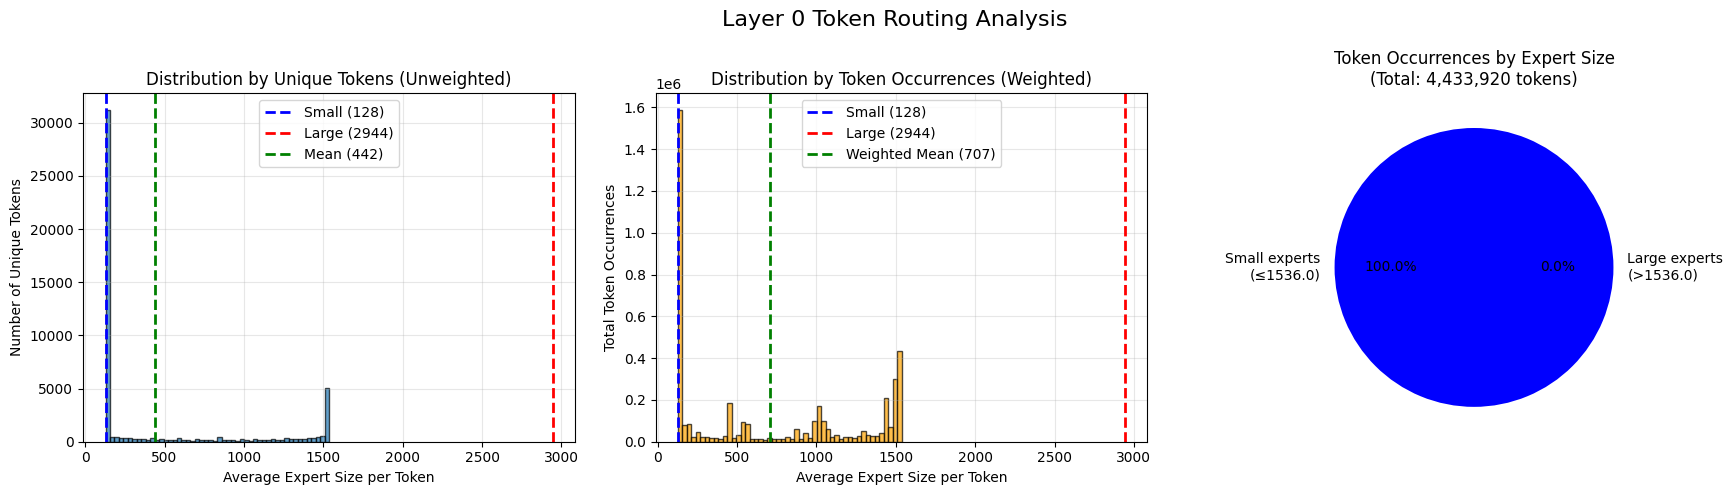

Average Expert Size Statistics (Unweighted):
  Mean: 441.73
  Median: 128.00
  Std: 522.11

Average Expert Size Statistics (Weighted by occurrences):
  Weighted Mean: 706.80

Unique Token routing breakdown:
  Unique tokens routing mostly to LARGE experts: 0 (0.0%)
  Unique tokens routing mostly to SMALL experts: 47586 (100.0%)

Weighted by occurrences:
  Token occurrences routed to LARGE experts: 0 (0.0%)
  Token occurrences routed to SMALL experts: 4,433,920 (100.0%)

LAYER 1 ANALYSIS



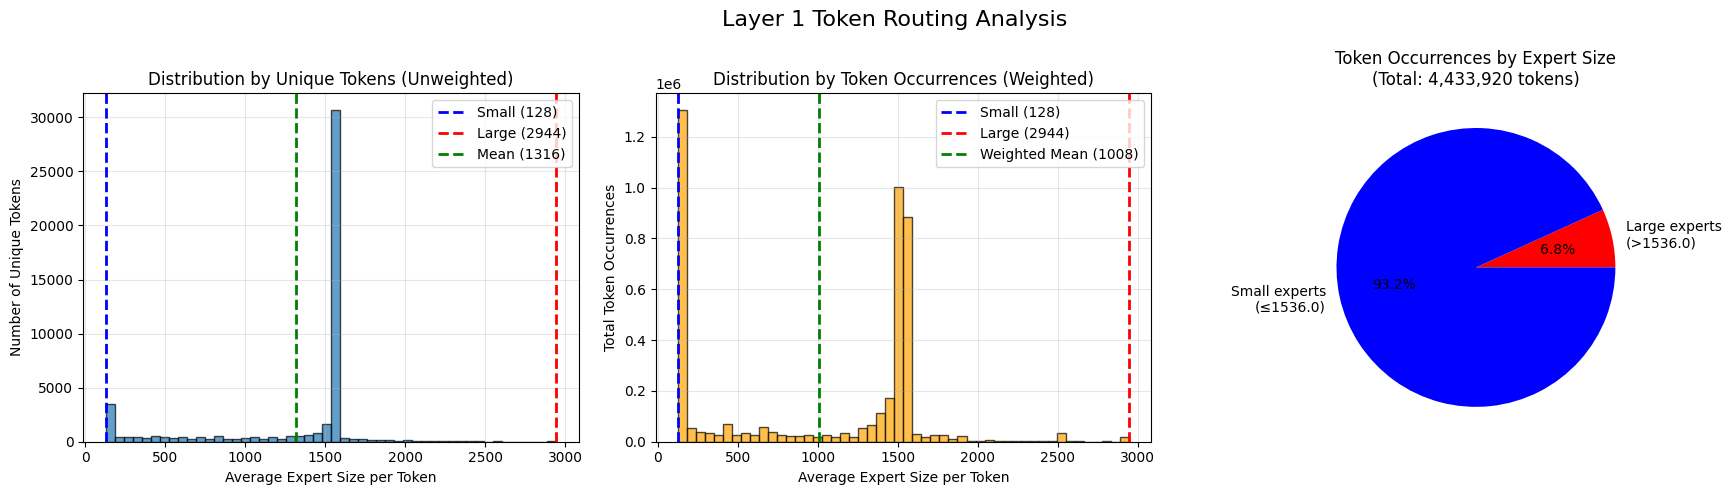

Average Expert Size Statistics (Unweighted):
  Mean: 1315.55
  Median: 1536.00
  Std: 482.88

Average Expert Size Statistics (Weighted by occurrences):
  Weighted Mean: 1007.70

Unique Token routing breakdown:
  Unique tokens routing mostly to LARGE experts: 2597 (5.5%)
  Unique tokens routing mostly to SMALL experts: 44989 (94.5%)

Weighted by occurrences:
  Token occurrences routed to LARGE experts: 301,004 (6.8%)
  Token occurrences routed to SMALL experts: 4,132,916 (93.2%)

LAYER 2 ANALYSIS



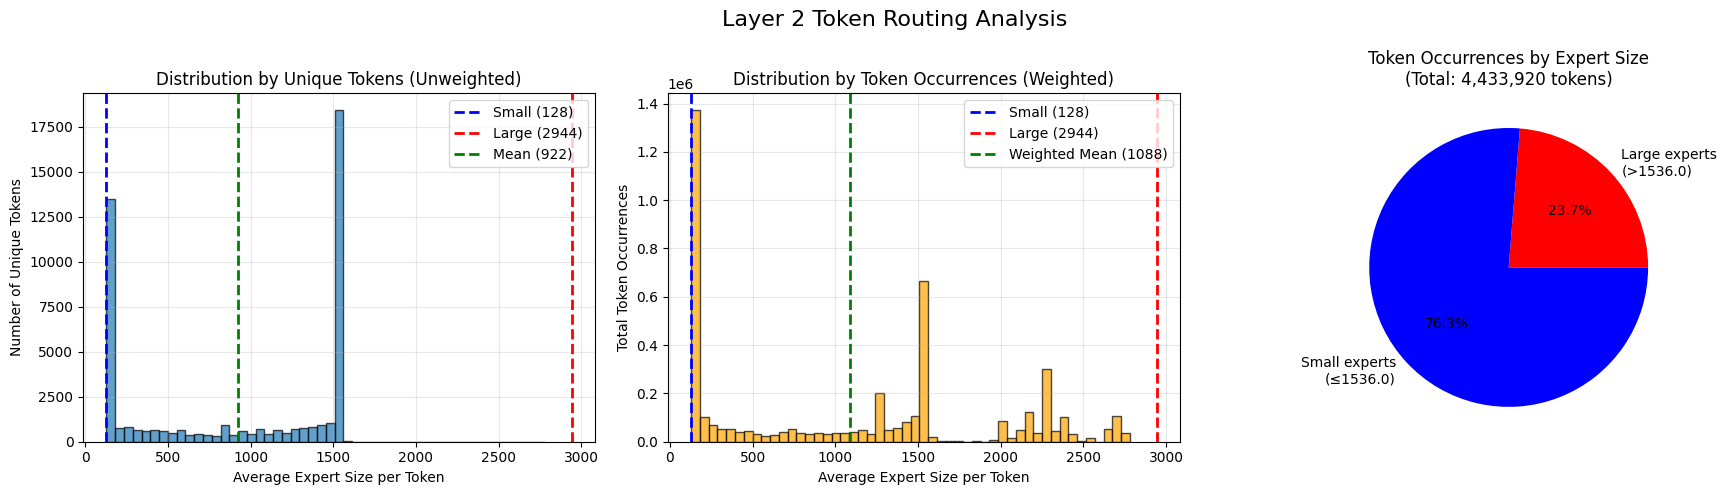

Average Expert Size Statistics (Unweighted):
  Mean: 922.06
  Median: 1152.00
  Std: 619.74

Average Expert Size Statistics (Weighted by occurrences):
  Weighted Mean: 1088.40

Unique Token routing breakdown:
  Unique tokens routing mostly to LARGE experts: 109 (0.2%)
  Unique tokens routing mostly to SMALL experts: 47477 (99.8%)

Weighted by occurrences:
  Token occurrences routed to LARGE experts: 1,051,551 (23.7%)
  Token occurrences routed to SMALL experts: 3,382,369 (76.3%)

LAYER 3 ANALYSIS



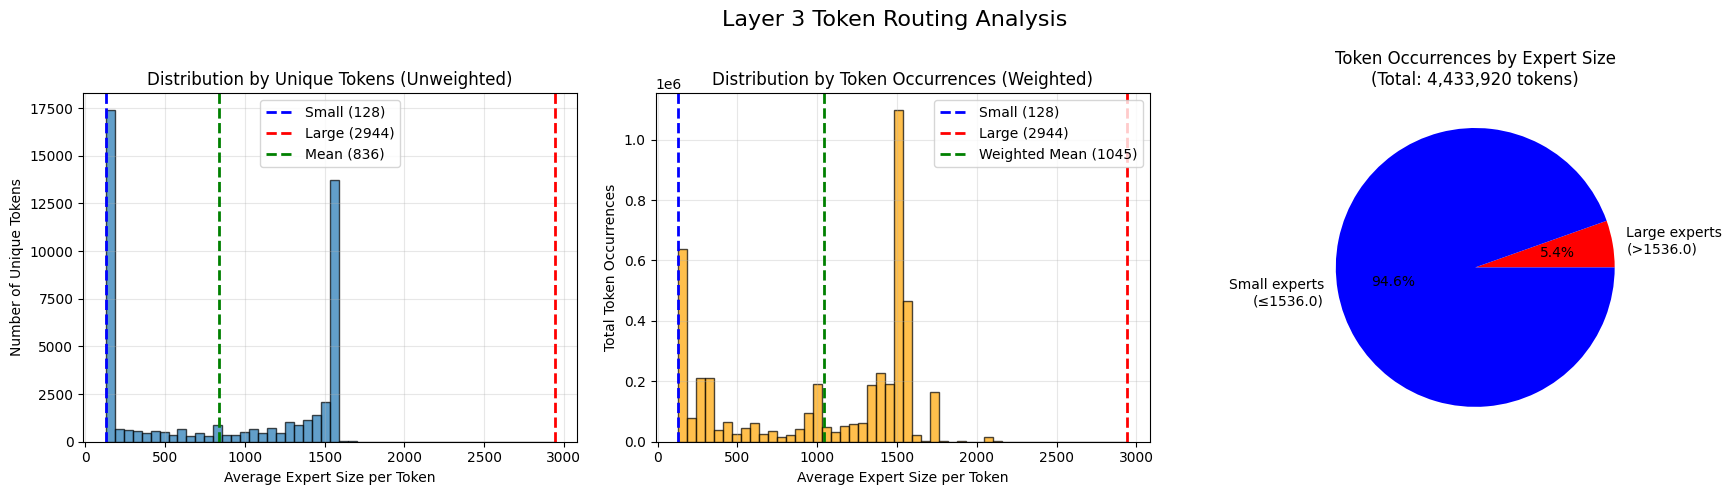

Average Expert Size Statistics (Unweighted):
  Mean: 836.28
  Median: 882.29
  Std: 631.26

Average Expert Size Statistics (Weighted by occurrences):
  Weighted Mean: 1045.23

Unique Token routing breakdown:
  Unique tokens routing mostly to LARGE experts: 149 (0.3%)
  Unique tokens routing mostly to SMALL experts: 47437 (99.7%)

Weighted by occurrences:
  Token occurrences routed to LARGE experts: 240,691 (5.4%)
  Token occurrences routed to SMALL experts: 4,193,229 (94.6%)

LAYER 4 ANALYSIS



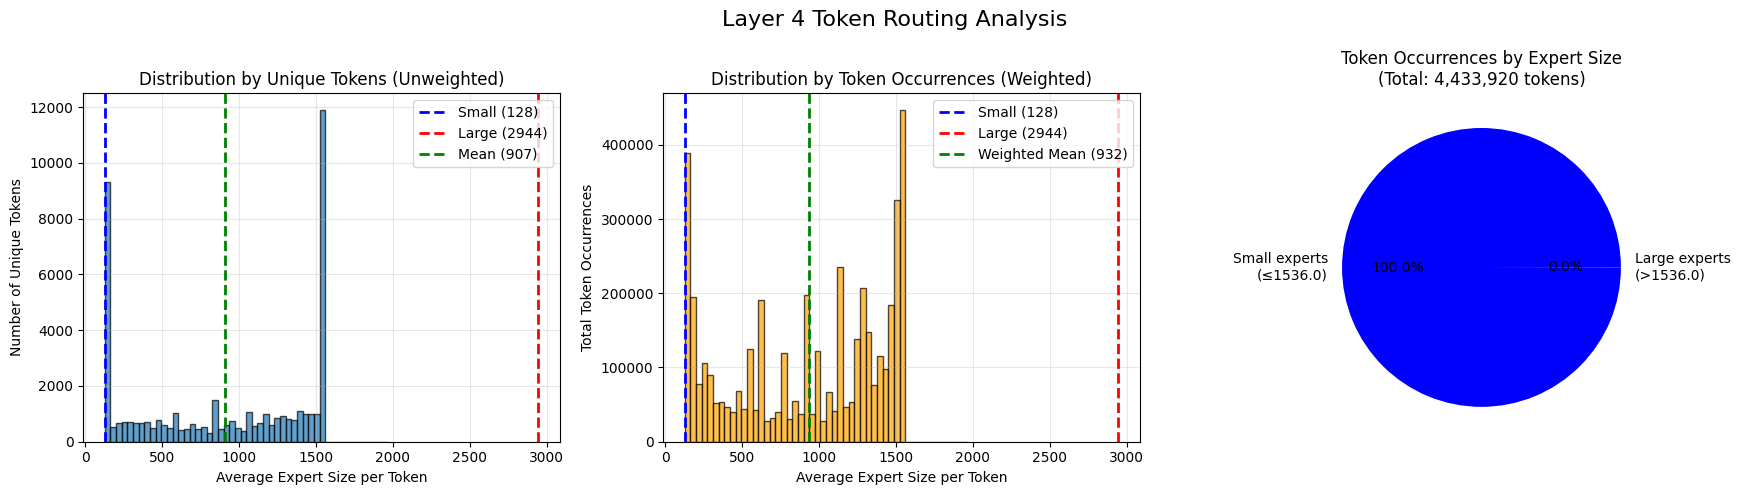

Average Expert Size Statistics (Unweighted):
  Mean: 907.25
  Median: 1008.00
  Std: 555.76

Average Expert Size Statistics (Weighted by occurrences):
  Weighted Mean: 932.27

Unique Token routing breakdown:
  Unique tokens routing mostly to LARGE experts: 4 (0.0%)
  Unique tokens routing mostly to SMALL experts: 47582 (100.0%)

Weighted by occurrences:
  Token occurrences routed to LARGE experts: 1,447 (0.0%)
  Token occurrences routed to SMALL experts: 4,432,473 (100.0%)

LAYER 5 ANALYSIS



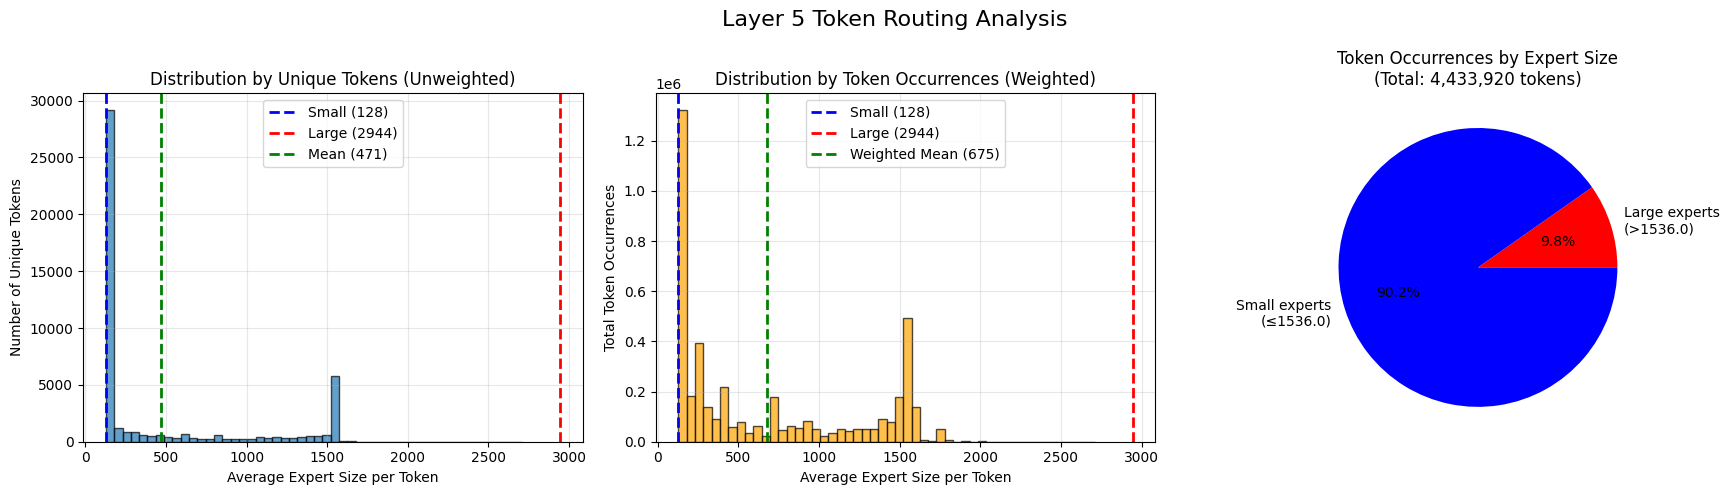

Average Expert Size Statistics (Unweighted):
  Mean: 470.67
  Median: 128.00
  Std: 534.96

Average Expert Size Statistics (Weighted by occurrences):
  Weighted Mean: 675.36

Unique Token routing breakdown:
  Unique tokens routing mostly to LARGE experts: 290 (0.6%)
  Unique tokens routing mostly to SMALL experts: 47296 (99.4%)

Weighted by occurrences:
  Token occurrences routed to LARGE experts: 432,359 (9.8%)
  Token occurrences routed to SMALL experts: 4,001,561 (90.2%)

LAYER 6 ANALYSIS



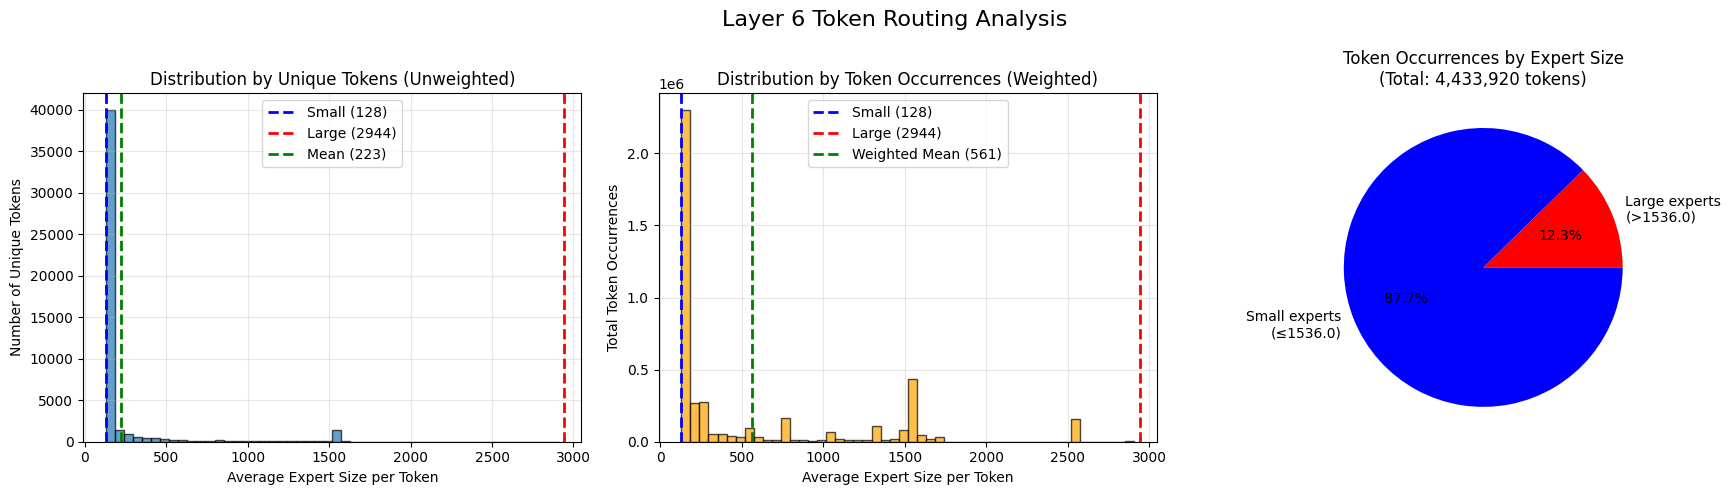

Average Expert Size Statistics (Unweighted):
  Mean: 223.26
  Median: 128.00
  Std: 301.47

Average Expert Size Statistics (Weighted by occurrences):
  Weighted Mean: 561.12

Unique Token routing breakdown:
  Unique tokens routing mostly to LARGE experts: 183 (0.4%)
  Unique tokens routing mostly to SMALL experts: 47403 (99.6%)

Weighted by occurrences:
  Token occurrences routed to LARGE experts: 545,371 (12.3%)
  Token occurrences routed to SMALL experts: 3,888,549 (87.7%)

LAYER 7 ANALYSIS



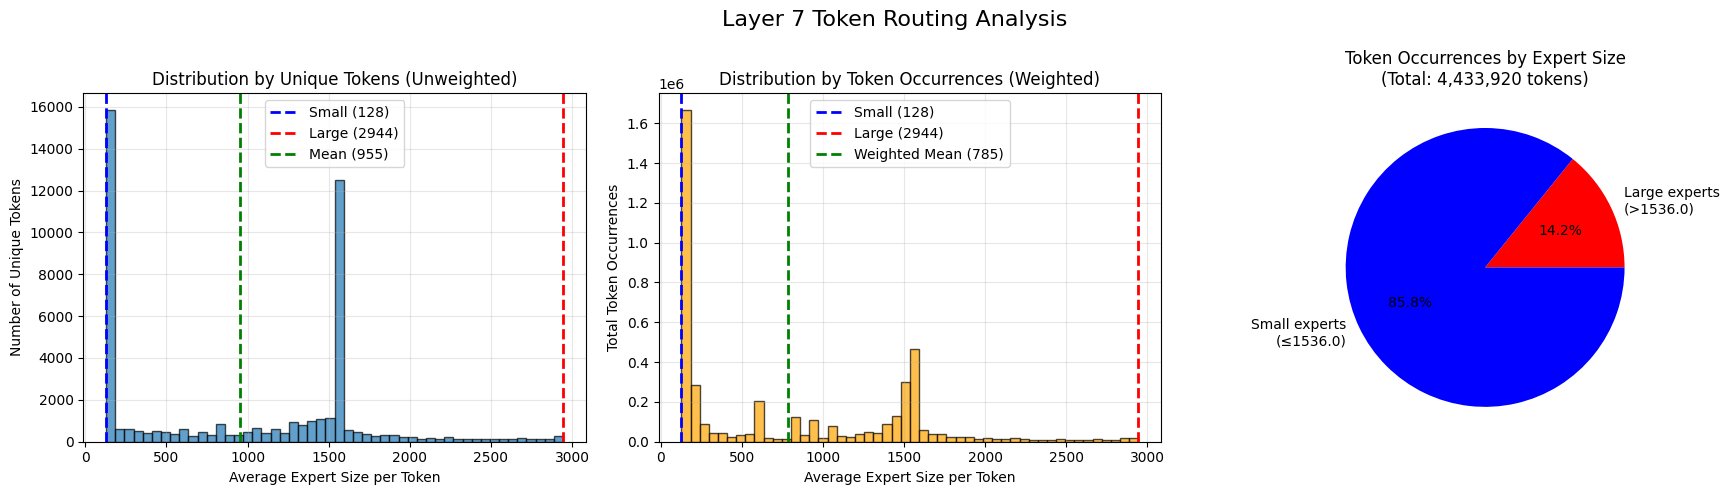

Average Expert Size Statistics (Unweighted):
  Mean: 955.40
  Median: 1118.81
  Std: 727.63

Average Expert Size Statistics (Weighted by occurrences):
  Weighted Mean: 785.45

Unique Token routing breakdown:
  Unique tokens routing mostly to LARGE experts: 5666 (11.9%)
  Unique tokens routing mostly to SMALL experts: 41920 (88.1%)

Weighted by occurrences:
  Token occurrences routed to LARGE experts: 628,910 (14.2%)
  Token occurrences routed to SMALL experts: 3,805,010 (85.8%)

LAYER 8 ANALYSIS



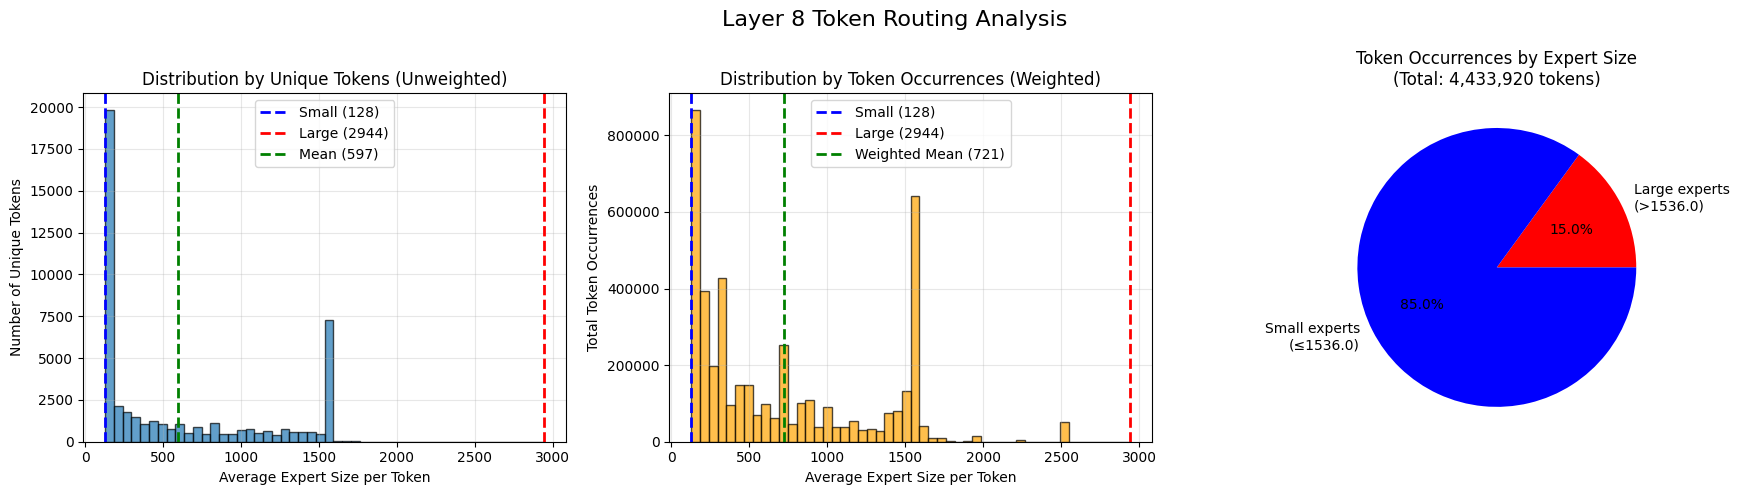

Average Expert Size Statistics (Unweighted):
  Mean: 596.51
  Median: 304.00
  Std: 552.25

Average Expert Size Statistics (Weighted by occurrences):
  Weighted Mean: 721.37

Unique Token routing breakdown:
  Unique tokens routing mostly to LARGE experts: 315 (0.7%)
  Unique tokens routing mostly to SMALL experts: 47271 (99.3%)

Weighted by occurrences:
  Token occurrences routed to LARGE experts: 663,871 (15.0%)
  Token occurrences routed to SMALL experts: 3,770,049 (85.0%)

LAYER 9 ANALYSIS



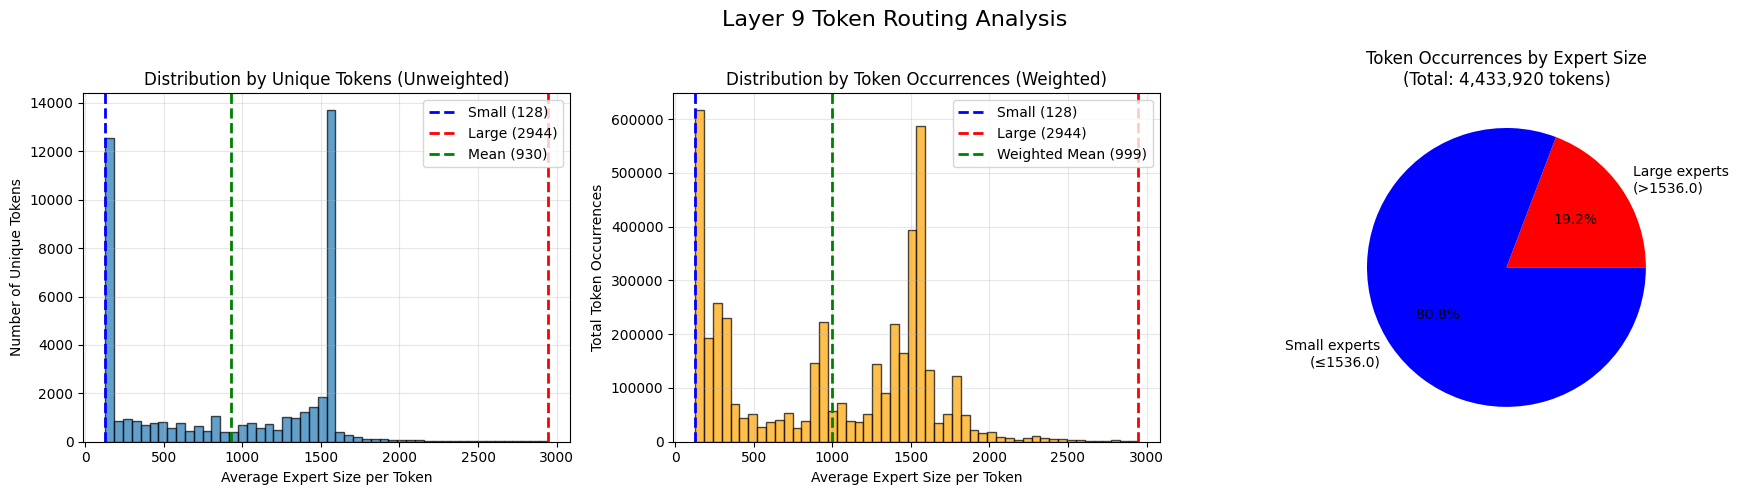

Average Expert Size Statistics (Unweighted):
  Mean: 929.72
  Median: 1096.94
  Std: 628.08

Average Expert Size Statistics (Weighted by occurrences):
  Weighted Mean: 999.44

Unique Token routing breakdown:
  Unique tokens routing mostly to LARGE experts: 2534 (5.3%)
  Unique tokens routing mostly to SMALL experts: 45052 (94.7%)

Weighted by occurrences:
  Token occurrences routed to LARGE experts: 852,260 (19.2%)
  Token occurrences routed to SMALL experts: 3,581,660 (80.8%)

LAYER 10 ANALYSIS



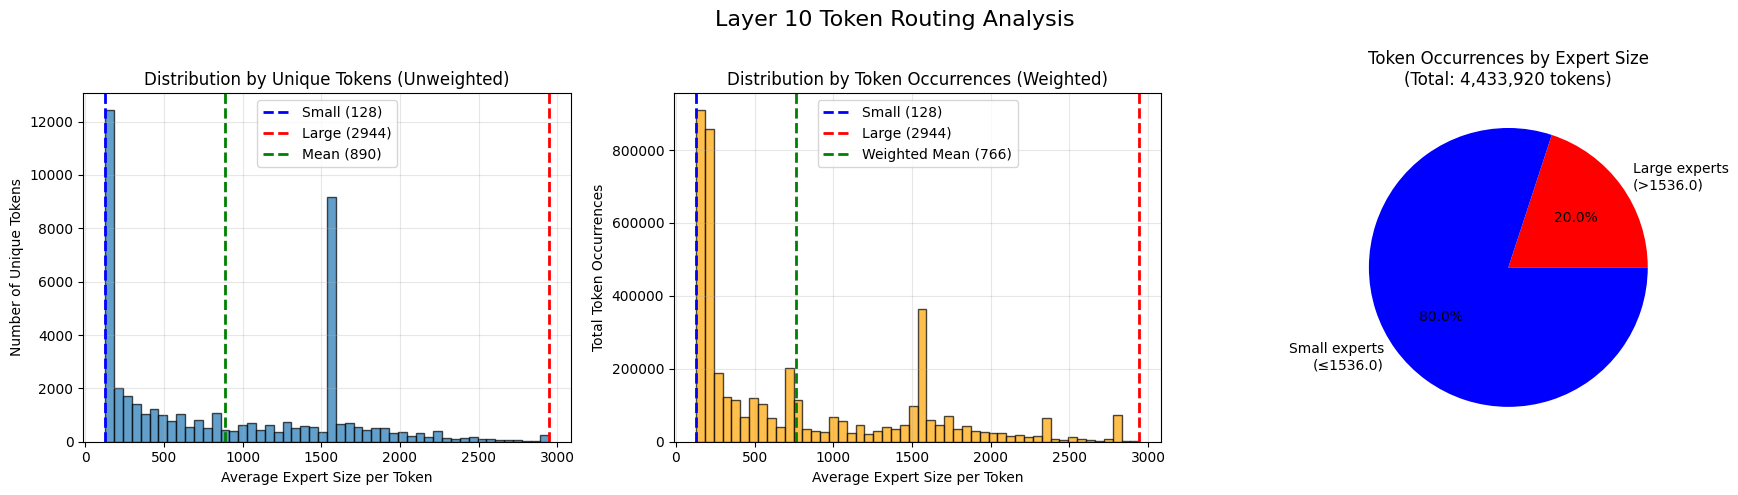

Average Expert Size Statistics (Unweighted):
  Mean: 889.51
  Median: 731.43
  Std: 705.65

Average Expert Size Statistics (Weighted by occurrences):
  Weighted Mean: 766.06

Unique Token routing breakdown:
  Unique tokens routing mostly to LARGE experts: 6875 (14.4%)
  Unique tokens routing mostly to SMALL experts: 40711 (85.6%)

Weighted by occurrences:
  Token occurrences routed to LARGE experts: 884,910 (20.0%)
  Token occurrences routed to SMALL experts: 3,549,010 (80.0%)

LAYER 11 ANALYSIS



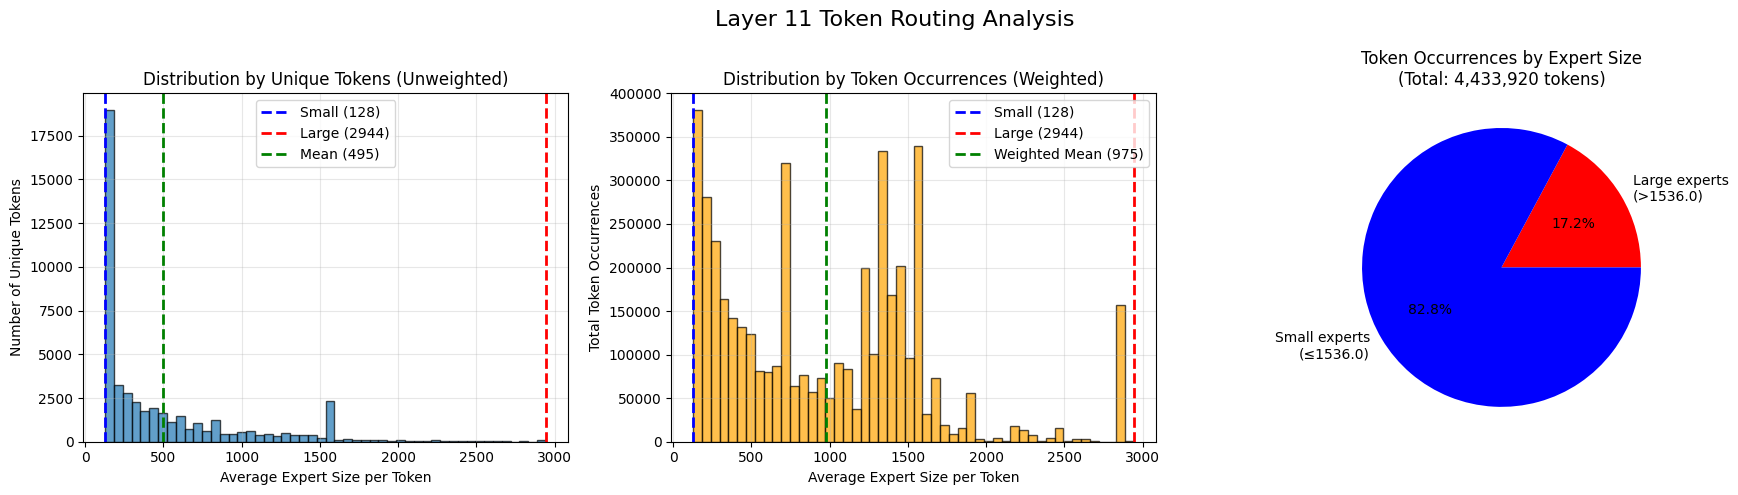

Average Expert Size Statistics (Unweighted):
  Mean: 494.62
  Median: 268.80
  Std: 500.26

Average Expert Size Statistics (Weighted by occurrences):
  Weighted Mean: 974.58

Unique Token routing breakdown:
  Unique tokens routing mostly to LARGE experts: 1448 (3.0%)
  Unique tokens routing mostly to SMALL experts: 46138 (97.0%)

Weighted by occurrences:
  Token occurrences routed to LARGE experts: 760,541 (17.2%)
  Token occurrences routed to SMALL experts: 3,673,379 (82.8%)

SUMMARY ACROSS ALL LAYERS


In [7]:
# Analyze per-token statistics FOR EACH LAYER
for layer_idx in range(num_layers):
    layer_name = f'layer_{layer_idx}'
    token_stats = token_stats_per_layer[layer_name]
    
    print(f"\n{'='*80}")
    print(f"LAYER {layer_idx} ANALYSIS")
    print(f"{'='*80}\n")
    
    # Compute derived metrics for each token
    token_analysis = {}
    
    for token_id, stats in token_stats.items():
        if stats['total_occurrences'] > 0:
            # Average entropy
            avg_entropy = stats['total_entropy'] / stats['total_occurrences']
            
            # Expert distribution (normalized)
            expert_distribution = stats['expert_counts'] / stats['expert_counts'].sum()
            
            # Most common expert
            most_common_expert = np.argmax(stats['expert_counts'])
            
            # Average expert size
            avg_expert_size = stats['expert_size_sum'] / stats['expert_counts'].sum()
            
            token_analysis[token_id] = {
                'avg_entropy': avg_entropy,
                'occurrences': stats['total_occurrences'],
                'expert_distribution': expert_distribution,
                'most_common_expert': most_common_expert,
                'avg_expert_size': avg_expert_size,
            }
    
    # Plot distribution of average expert sizes
    all_expert_sizes = np.array([a['avg_expert_size'] for a in token_analysis.values()])
    all_occurrences = np.array([a['occurrences'] for a in token_analysis.values()])
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Layer {layer_idx} Token Routing Analysis', fontsize=16)
    
    # Unweighted histogram (by unique tokens)
    ax1 = axes[0]
    ax1.hist(all_expert_sizes, bins=50, alpha=0.7, edgecolor='black')
    ax1.axvline(x=config.expert_sizes[1][1], color='blue', linestyle='--', label=f'Small ({config.expert_sizes[1][1]})', linewidth=2)
    ax1.axvline(x=config.expert_sizes[0][1], color='red', linestyle='--', label=f'Large ({config.expert_sizes[0][1]})', linewidth=2)
    ax1.axvline(x=np.mean(all_expert_sizes), color='green', linestyle='--', label=f'Mean ({np.mean(all_expert_sizes):.0f})', linewidth=2)
    ax1.set_xlabel('Average Expert Size per Token')
    ax1.set_ylabel('Number of Unique Tokens')
    ax1.set_title('Distribution by Unique Tokens (Unweighted)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Weighted histogram (by token occurrences)
    ax2 = axes[1]
    ax2.hist(all_expert_sizes, bins=50, weights=all_occurrences, alpha=0.7, edgecolor='black', color='orange')
    ax2.axvline(x=config.expert_sizes[1][1], color='blue', linestyle='--', label=f'Small ({config.expert_sizes[1][1]})', linewidth=2)
    ax2.axvline(x=config.expert_sizes[0][1], color='red', linestyle='--', label=f'Large ({config.expert_sizes[0][1]})', linewidth=2)
    weighted_mean = np.average(all_expert_sizes, weights=all_occurrences)
    ax2.axvline(x=weighted_mean, color='green', linestyle='--', label=f'Weighted Mean ({weighted_mean:.0f})', linewidth=2)
    ax2.set_xlabel('Average Expert Size per Token')
    ax2.set_ylabel('Total Token Occurrences')
    ax2.set_title('Distribution by Token Occurrences (Weighted)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Pie chart - weighted breakdown
    ax3 = axes[2]
    large_expert_occurrences = sum(all_occurrences[all_expert_sizes > (config.n_embd * 4)/2])
    small_expert_occurrences = sum(all_occurrences[all_expert_sizes <= (config.n_embd * 4)/2])
    total_occurrences = large_expert_occurrences + small_expert_occurrences
    
    ax3.pie([large_expert_occurrences, small_expert_occurrences],
            labels=[f'Large experts\n(>{(config.n_embd * 4)/2})', f'Small experts\n(≤{(config.n_embd * 4)/2})'],
            autopct='%1.1f%%',
            colors=['red', 'blue'])
    ax3.set_title(f'Token Occurrences by Expert Size\n(Total: {total_occurrences:,} tokens)')
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"Average Expert Size Statistics (Unweighted):")
    print(f"  Mean: {np.mean(all_expert_sizes):.2f}")
    print(f"  Median: {np.median(all_expert_sizes):.2f}")
    print(f"  Std: {np.std(all_expert_sizes):.2f}")
    
    print(f"\nAverage Expert Size Statistics (Weighted by occurrences):")
    print(f"  Weighted Mean: {weighted_mean:.2f}")
    
    # Count how many tokens go to mostly large vs mostly small experts
    large_expert_tokens = sum(1 for s in all_expert_sizes if s > (config.n_embd * 4)/2)
    small_expert_tokens = sum(1 for s in all_expert_sizes if s <= (config.n_embd * 4)/2)
    print(f"\nUnique Token routing breakdown:")
    print(f"  Unique tokens routing mostly to LARGE experts: {large_expert_tokens} ({100*large_expert_tokens/len(all_expert_sizes):.1f}%)")
    print(f"  Unique tokens routing mostly to SMALL experts: {small_expert_tokens} ({100*small_expert_tokens/len(all_expert_sizes):.1f}%)")
    
    print(f"\nWeighted by occurrences:")
    print(f"  Token occurrences routed to LARGE experts: {large_expert_occurrences:,} ({100*large_expert_occurrences/total_occurrences:.1f}%)")
    print(f"  Token occurrences routed to SMALL experts: {small_expert_occurrences:,} ({100*small_expert_occurrences/total_occurrences:.1f}%)")

print("\n" + "="*80)
print("SUMMARY ACROSS ALL LAYERS")
print("="*80)

In [9]:
import pandas as pd
dfs = {}
for seed in [42, 1223, 1337]:
    # checkpoint_dir = f"out-openwebtext/moe-8x2-variable-4x2944-4x128-seed{seed}
    checkpoint_dir = f"gpt2_experiments/multiseed_23to1_20251102_203832/ratio23_lbl0.01_compute0.004_seed{seed}"
    checkpoint_path = f"{checkpoint_dir}/ckpt.pt"
    sweep_value = '-'.join(checkpoint_path.split('-')).split('/')[-2]
    dfs[seed] = pd.read_csv(f'analysis_csvs/{sweep_value}_expert_combinations.csv')

In [10]:
import numpy as np
import pandas as pd

# Merge all three seeds
df = dfs[42].merge(dfs[1223], on='token', suffixes=('_42', '_1223'))
df = df.merge(dfs[1337], on='token')
df = df.rename(columns={'avg_size': 'avg_size_1337'})

# Calculate range (max - min) across all three seeds
df['max_size'] = df[['avg_size_42', 'avg_size_1223', 'avg_size_1337']].max(axis=1)
df['min_size'] = df[['avg_size_42', 'avg_size_1223', 'avg_size_1337']].min(axis=1)
df['range'] = df['max_size'] - df['min_size']
df['mean_size'] = df[['avg_size_42', 'avg_size_1223', 'avg_size_1337']].mean(axis=1)

# Create different bucket sizes
df['all_exact'] = (
    np.isclose(df['avg_size_42'], df['avg_size_1223']) & 
    np.isclose(df['avg_size_1223'], df['avg_size_1337'])
)
exact_bucket = df[df['all_exact']].copy()
tight_bucket = df[df['range'] <= 235].copy()
medium_bucket = df[df['range'] <= 470].copy()
wide_bucket = df[df['range'] <= 705].copy()

print(f"Exact bucket:         {len(exact_bucket):,} tokens ({100*len(exact_bucket)/len(df):.1f}%)")
print(f"Tight bucket (±235):  {len(tight_bucket):,} tokens ({100*len(tight_bucket)/len(df):.1f}%)")
print(f"Medium bucket (±470): {len(medium_bucket):,} tokens ({100*len(medium_bucket)/len(df):.1f}%)")
print(f"Wide bucket (±705):   {len(wide_bucket):,} tokens ({100*len(wide_bucket)/len(df):.1f}%)")

# Save to CSV
exact_bucket.to_csv('analysis_csvs/owt_same_avg_size_tokens_bucket_exact.csv', index=False)
tight_bucket.to_csv('analysis_csvs/owt_same_avg_size_tokens_bucket_235.csv', index=False)
medium_bucket.to_csv('analysis_csvs/owt_same_avg_size_tokens_bucket_470.csv', index=False)
wide_bucket.to_csv('analysis_csvs/owt_same_avg_size_tokens_bucket_705.csv', index=False)

print("\nSaved buckets to:")
print("  - analysis_csvs/owt_same_avg_size_tokens_bucket_exact.csv")
print("  - analysis_csvs/owt_same_avg_size_tokens_bucket_235.csv")
print("  - analysis_csvs/owt_same_avg_size_tokens_bucket_470.csv")
print("  - analysis_csvs/owt_same_avg_size_tokens_bucket_705.csv")

Exact bucket:         2,774 tokens (5.8%)
Tight bucket (±235):  16,287 tokens (34.1%)
Medium bucket (±470): 32,133 tokens (67.2%)
Wide bucket (±705):   42,164 tokens (88.2%)

Saved buckets to:
  - analysis_csvs/owt_same_avg_size_tokens_bucket_exact.csv
  - analysis_csvs/owt_same_avg_size_tokens_bucket_235.csv
  - analysis_csvs/owt_same_avg_size_tokens_bucket_470.csv
  - analysis_csvs/owt_same_avg_size_tokens_bucket_705.csv


In [14]:
df_vanilla = pd.read_csv('analysis_csvs/moe-8x2-8x1536_expert_combinations.csv')

In [20]:
exact_bucket_deduped = exact_bucket.drop_duplicates(subset='token')
df_vanilla_deduped = df_vanilla.drop_duplicates(subset='token')

result = exact_bucket_deduped.merge(df_vanilla_deduped, on='token', suffixes=('_exact', '_vanilla'))
result.to_csv('analysis_csvs/owt_same_avg_size_tokens_bucket_exact_vs_vanilla.csv', index=False)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('analysis_csvs/variable_experts_gpt2_data.csv')





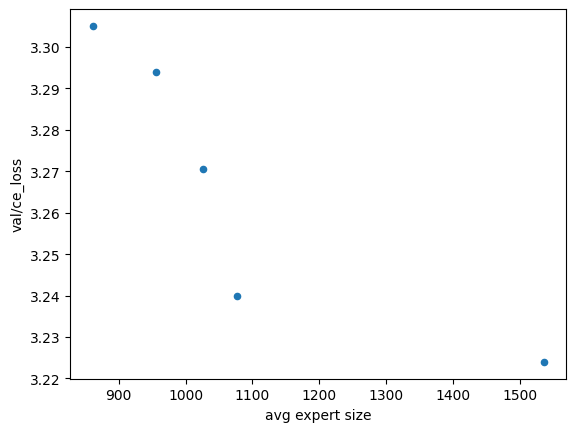

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('analysis_csvs/variable_experts_gpt2_data.csv')

df.plot(x='avg expert size', y='val/ce_loss', kind='scatter')
plt.show()

In [6]:
df

,Name,Large Expert Size,Small Expert Size,val/ce_loss,ce loss ratio,ce loss vs baseline % worse,Runtime,% Speedup,batch_size,compute_loss_weight,...,expert_usage/expert_3,expert_usage/expert_4,expert_usage/expert_5,expert_usage/expert_6,expert_usage/expert_7,expert_usage/max_usage,val/compute_loss,val/load_balance_loss,val/loss,val/router_z_loss
0,2944x128,2944,128,3.3051,102.52%,2.52%,19147,20.43%,12,0.004,...,0.059631,0.191815,0.191177,0.193657,0.163125,0.193657,0.717891,1.181172,3.319854,0.124031
1,2816x256,2816,256,3.2940,102.17%,2.17%,19870,16.05%,12,0.004,...,0.065894,0.179023,0.193045,0.188167,0.166438,0.193045,0.779512,1.141250,3.308658,0.119900
2,2688x384,2688,384,3.2706,101.45%,1.45%,20631,11.77%,12,0.004,...,0.061730,0.169945,0.197015,0.195136,0.159320,0.197015,0.820137,1.121992,3.285258,0.120714
3,2560x512,2560,512,3.2400,100.50%,0.50%,20899,10.34%,12,0.004,...,0.061910,0.174109,0.189557,0.204617,0.155855,0.204617,0.840020,1.126250,3.254778,0.125913
4,Baseline,1536,1536,3.2240,1,0.00%,23059,0.00%,12,0.004,...,0.119944,0.110306,0.128458,0.148325,0.132413,0.148325,1.000000,1.030703,3.238407,0.138451


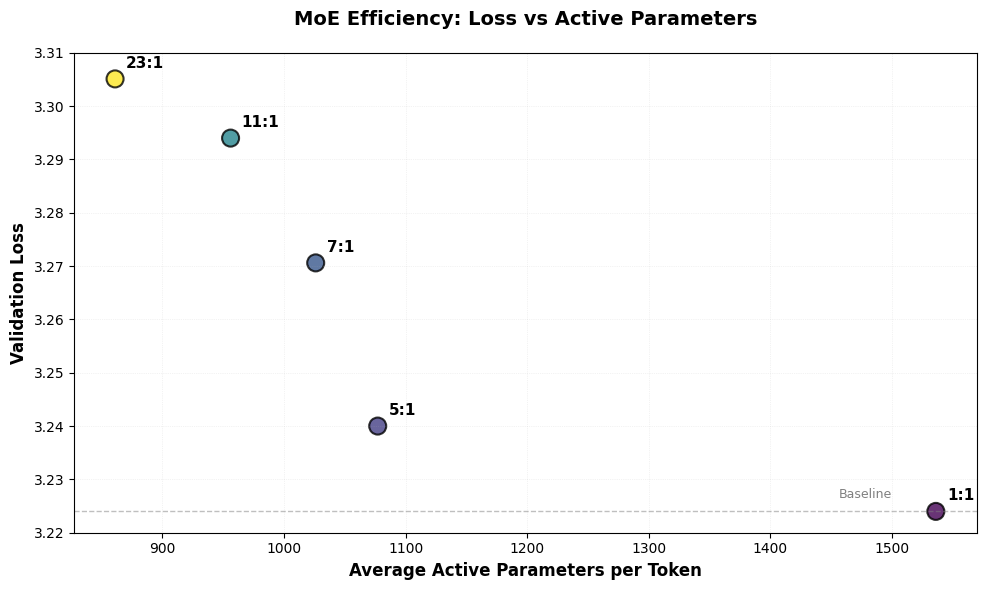

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('analysis_csvs/variable_experts_gpt2_data.csv')

# Create ratio labels manually based on the expert sizes
ratio_map = {
    'Baseline': '1:1',
    '2560x512': '5:1',
    '2688x384': '7:1',
    '2816x256': '11:1',
    '2944x128': '23:1'
}
df['ratio_label'] = df['Name'].map(ratio_map)

# Create numeric ratio for sorting/coloring
ratio_numeric = {
    'Baseline': 1,
    '2560x512': 5,
    '2688x384': 7,
    '2816x256': 11,
    '2944x128': 23
}
df['ratio'] = df['Name'].map(ratio_numeric)

fig, ax = plt.subplots(figsize=(10, 6))


ax.scatter(df['avg expert size'], df['val/ce_loss'], 
           c=df['ratio'], s=150, alpha=0.8, edgecolors='black', linewidth=1.5)


for idx, row in df.iterrows():
    ax.annotate(row['ratio_label'], 
                (row['avg expert size'], row['val/ce_loss']),
                xytext=(8, 8), textcoords='offset points',
                fontsize=11, fontweight='bold')


baseline_loss = df[df['Name'] == 'Baseline']['val/ce_loss'].values[0]
baseline_params = df[df['Name'] == 'Baseline']['avg expert size'].values[0]
ax.axhline(baseline_loss, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.text(1500, baseline_loss + 0.002, 'Baseline', 
        ha='right', va='bottom', fontsize=9, color='gray')


ax.set_xlabel('Average Active Parameters per Token', fontsize=12, fontweight='bold')
ax.set_ylabel('Validation Loss', fontsize=12, fontweight='bold')
ax.set_title('MoE Efficiency: Loss vs Active Parameters', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
ax.set_ylim(3.22, 3.31)

plt.tight_layout()
plt.savefig('loss_vs_active_params.png', dpi=300, bbox_inches='tight')
plt.show()